# Palmer penguins in R

In [14]:
options(warn=-1)
library(palmerpenguins)
library(ggplot2)
library(GGally)
library(lattice)
library(caret)
library(randomForest)
library(tree)
library(explore)
library(tidyverse)
library(e1071)

# 1. Prepare data

## 1.1 Loading data
#### We start by loading the data we want to analyze

In [15]:
# Load data
data <- penguins 
dataset <- penguins

dataset[, c('sex', 'island')] <- sapply(dataset[, c('sex', 'island')], unclass)

sapply(dataset, class)
Y = dataset$species
Y_loc = 1
x_loc = 2:8

# Remove missing values
dim(dataset)
dataset <- na.omit(dataset)
dim(dataset)

# Split into train and valid
split_ratio = 0.75
validation_index <- createDataPartition(dataset$species, p=split_ratio, list = FALSE)
validation <- dataset[-validation_index,]
validation = data.frame(validation)

dataset <- dataset[validation_index,]

species            island    bill_length_mm     bill_depth_mm 
         "factor"         "integer"         "numeric"         "numeric" 
flipper_length_mm       body_mass_g               sex              year 
        "integer"         "integer"         "integer"         "integer"

[1] 344   8

[1] 333   8

# 2. Visualization the dataset

### 2.1 Pairplot

#### From the pairplot, we can see that the diagonal plots (i.e., the distribution plots) shows some interesting patterns. 

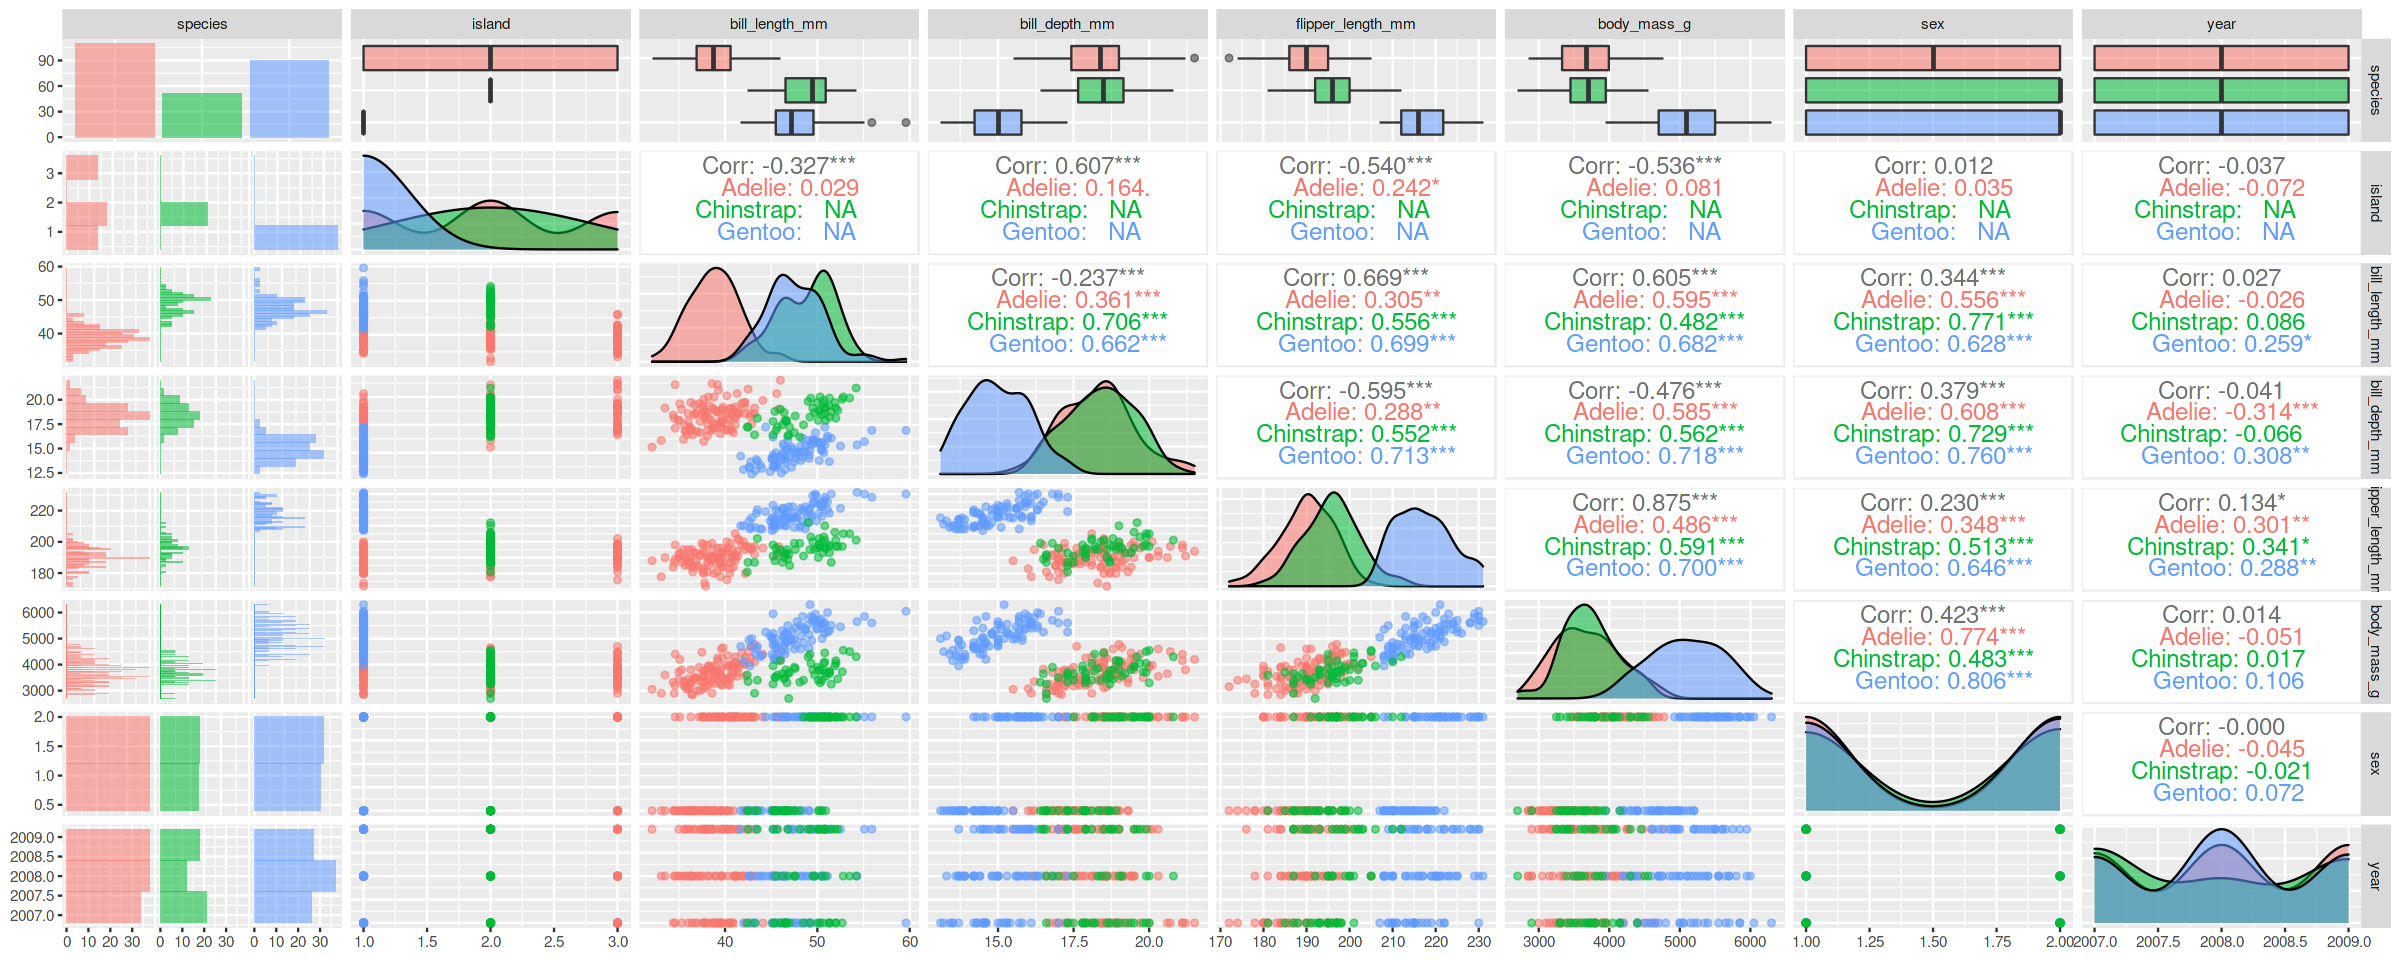

In [16]:
data(tips, package="reshape")
options(repr.plot.width=20, repr.plot.height=8)
ggpairs(dataset, lower=list(combo=wrap("facethist", binwidth=0.8)),
        columns = 1:length(dataset),
        aes(color = species,
            alpha = 0.5),
       upper = list(continuous = wrap("cor", size = 5)))

## 2.2 Boxplot

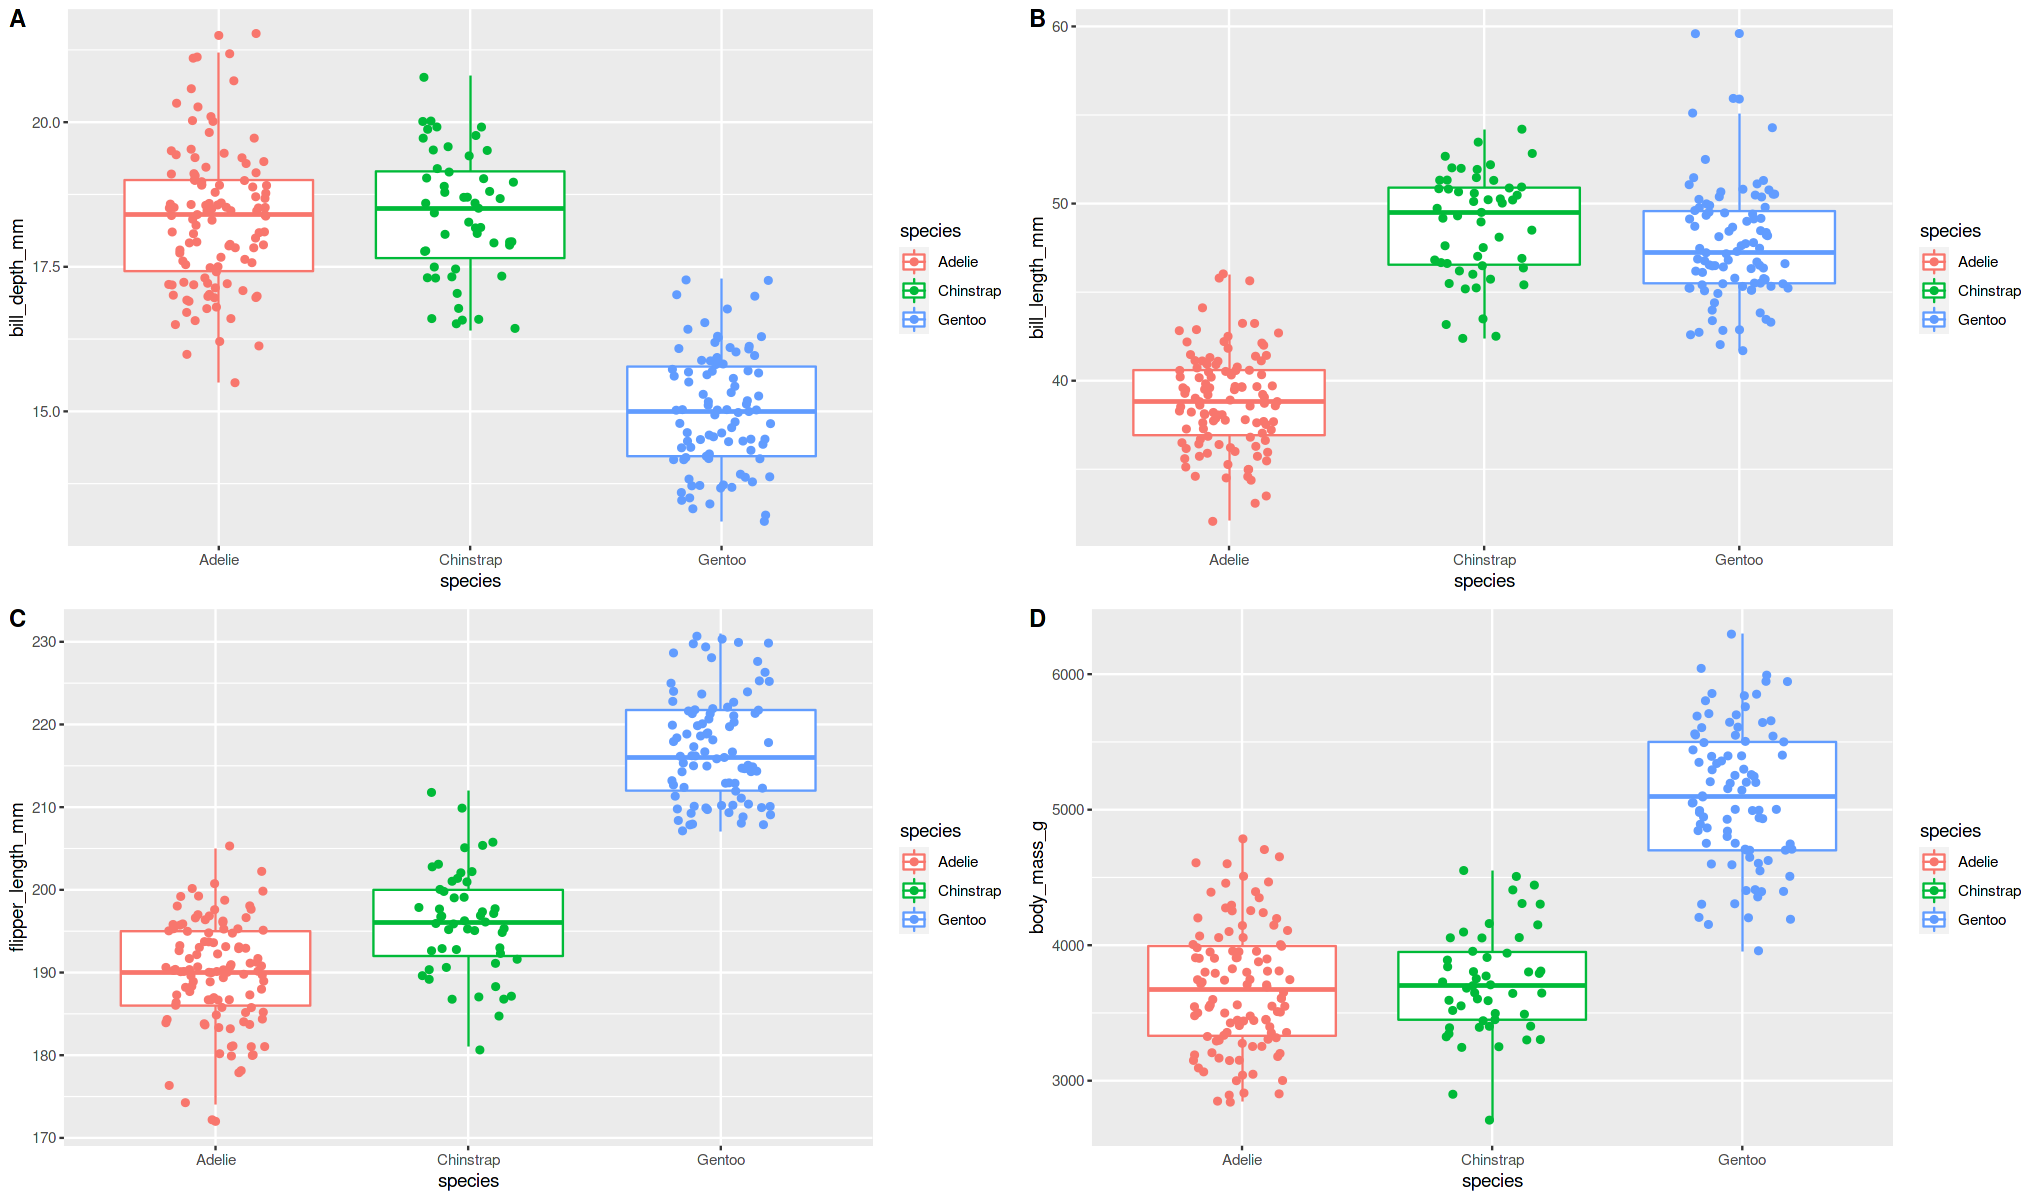

In [17]:
library(cowplot)
options(repr.plot.width=17, repr.plot.height=10)
plot1 <- ggplot(dataset) +
  aes(x = species, y = bill_depth_mm, color = species) +
  geom_boxplot() +
  geom_jitter(position = position_jitter(0.2))

plot2 <- ggplot(dataset) +
  aes(x = species, y = bill_length_mm, color = species) +
  geom_boxplot() +
  geom_jitter(position = position_jitter(0.2))

plot3 <- ggplot(dataset) +
  aes(x = species, y = flipper_length_mm, color = species) +
  geom_boxplot() +
  geom_jitter(position = position_jitter(0.2))

plot4 <- ggplot(dataset) +
  aes(x = species, y = body_mass_g, color = species) +
  geom_boxplot() +
  geom_jitter(position = position_jitter(0.2))

plot_grid(plot1,plot2,plot3,plot4, labels = "AUTO")

## 2.3 Correlation matrix

In [18]:
dataset %>%
    select_if(is.numeric) %>%
    cor()

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
island,1.00000000,-0.32692133,0.60715953,-0.5401643,-0.53571517,0.0118338738,-0.0369903675
bill_length_mm,-0.32692133,1.00000000,-0.23650473,0.6694021,0.60529986,0.3441110007,0.0266704073
bill_depth_mm,0.60715953,-0.23650473,1.00000000,-0.5953554,-0.47629973,0.3793533550,-0.0412851830
flipper_length_mm,-0.54016427,0.66940210,-0.59535541,1.0000000,0.87477132,0.2302317098,0.1337006911
body_mass_g,-0.53571517,0.60529986,-0.47629973,0.8747713,1.00000000,0.4234178690,0.0136669104
sex,0.01183387,0.34411100,0.37935336,0.2302317,0.42341787,1.0000000000,-0.0001178341
year,-0.03699037,0.02667041,-0.04128518,0.1337007,0.01366691,-0.0001178341,1.0000000000


# 3. Feature analysis

#### We now use RFECV and a decision tree to investigate which of our features are important. 


## 3.1 Decision tree
#### From the decision tree, we see that flipper length, bill length, bill depth, island and body mass are considered important. 

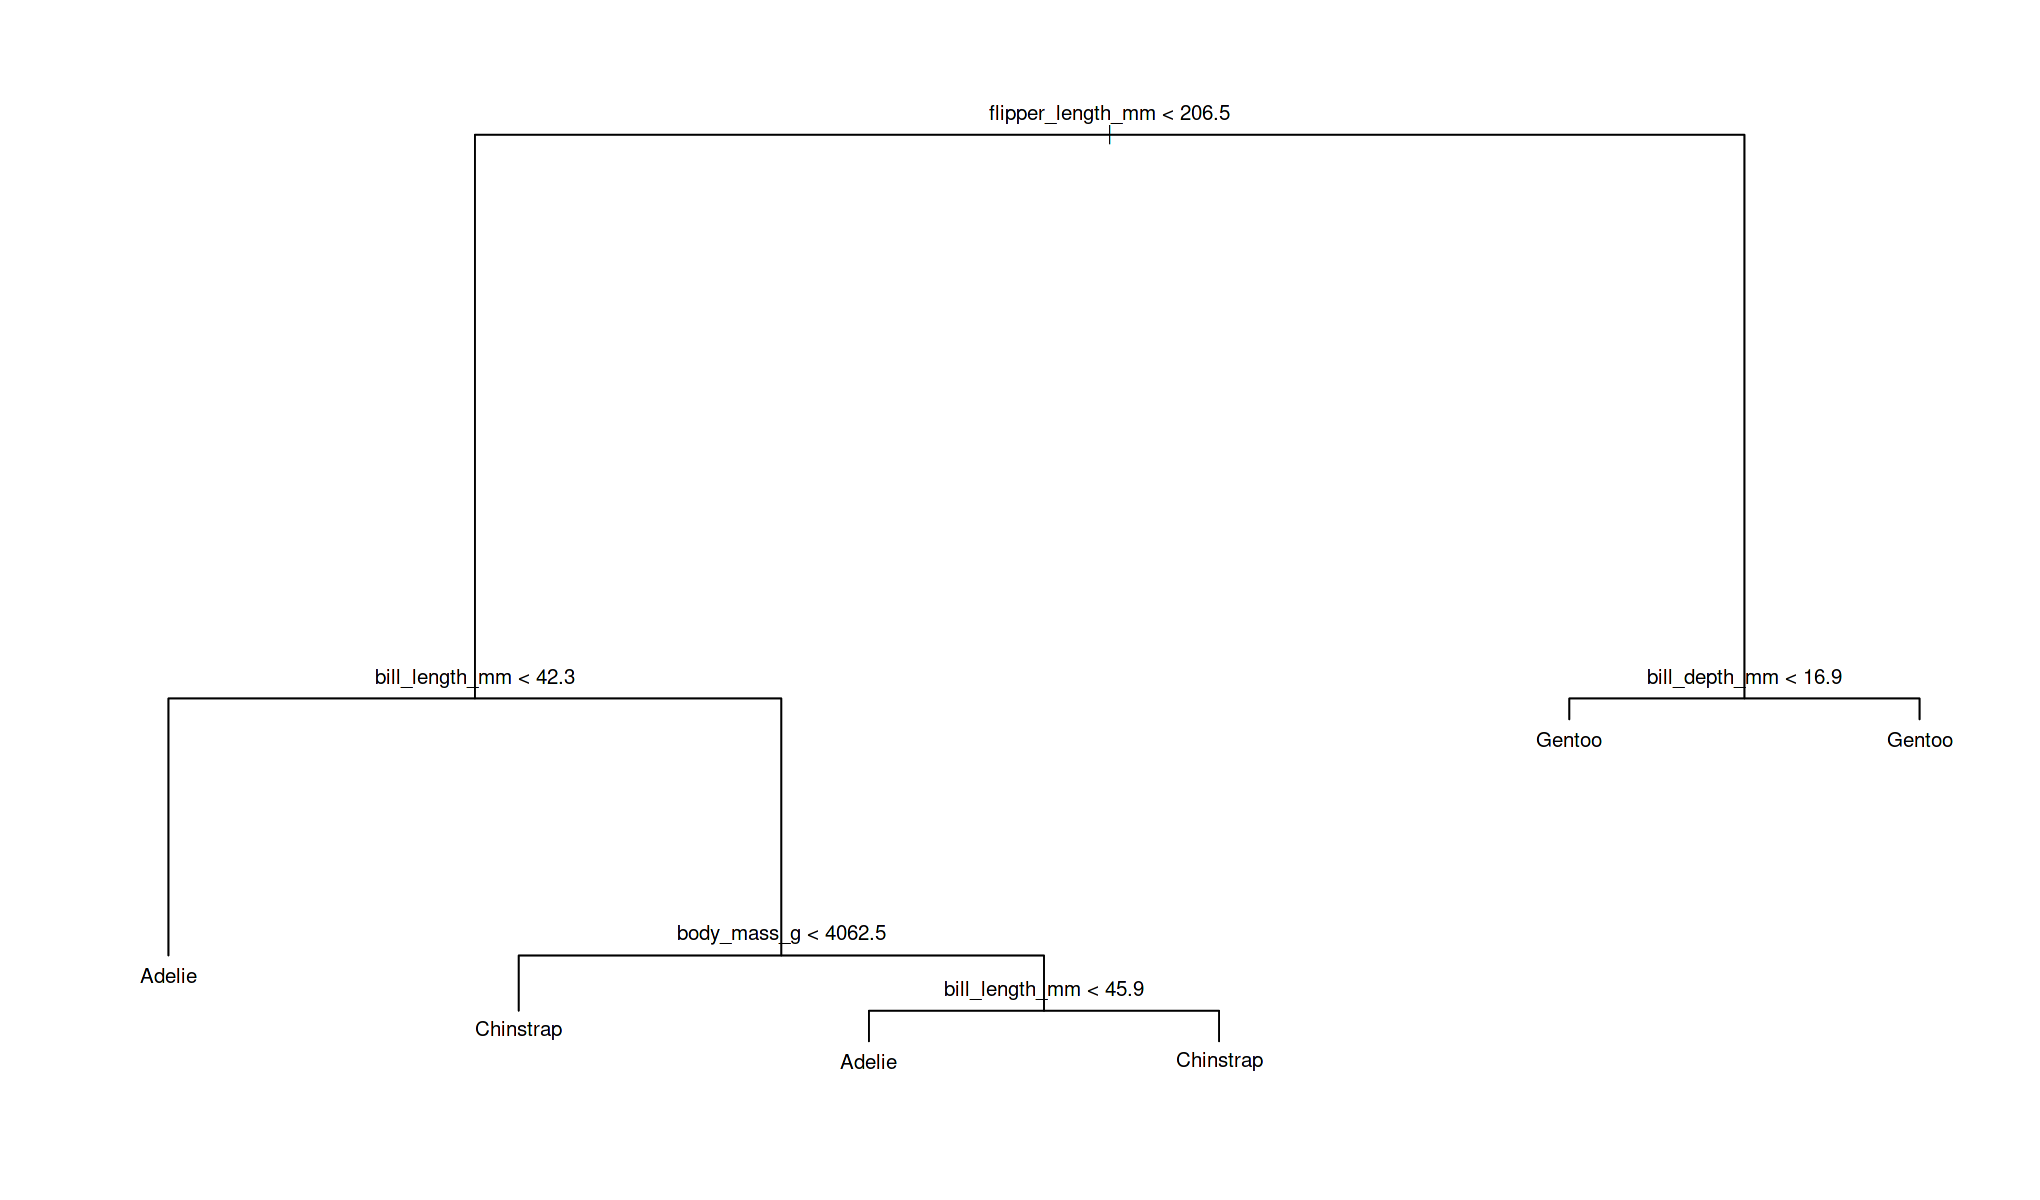

In [19]:
decision_tree <- tree(species ~ ., data = dataset)
# decision_tree
# summary(decision_tree)

plot(decision_tree)
text(decision_tree, pretty = 0)

## 3.2 RFECV
#### From the RFECV, we see that it matches well with our decision trees, i.e., sex and year are not very important for the model.

In [20]:
control <- trainControl(method="repeatedcv", number=10, repeats=3)
model <- train(species~., data=dataset, method="rf", preProcess="scale", trControl=control)
importance <- varImp(model, scale=FALSE)
print(importance)

rf variable importance

                  Overall
bill_length_mm     55.423
flipper_length_mm  38.366
bill_depth_mm      27.421
island             17.838
body_mass_g        17.769
sex                 1.166
year                1.040


# 4. Modelling

## 4.1 Full model

In [21]:
classifier <- randomForest(species ~., data = dataset, importance = T) 

predicted_table <- predict(classifier,
                           validation[,x_loc])
table(observed = validation[,Y_loc], predicted = predicted_table)

           predicted
observed    Adelie Chinstrap Gentoo
  Adelie        35         1      0
  Chinstrap      1        16      0
  Gentoo         0         0     29

## 4.2 Reduced model

#### In the reduced model, we don't use the features sex and years.

In [22]:
vars = c(1,3,4,5,6)
vars2 = c(3,4,5,6)
classifier <- randomForest(species ~., data = dataset[vars],importance = T,
                          maxnodes = 11, ntree = 500) 

predicted_table <- predict(classifier,
                           validation[,vars2])
table(observed = validation[,Y_loc], predicted = predicted_table)


           predicted
observed    Adelie Chinstrap Gentoo
  Adelie        35         0      1
  Chinstrap      1        16      0
  Gentoo         0         1     28

## 4.3 Further reduced model

#### If we reduce the model further, to only bill length and bill depth, we observe that we still get a pretty good model, with only 1 more misclassification.

           predicted
observed    Adelie Chinstrap Gentoo
  Adelie        35         1      0
  Chinstrap      1        16      0
  Gentoo         0         0     29

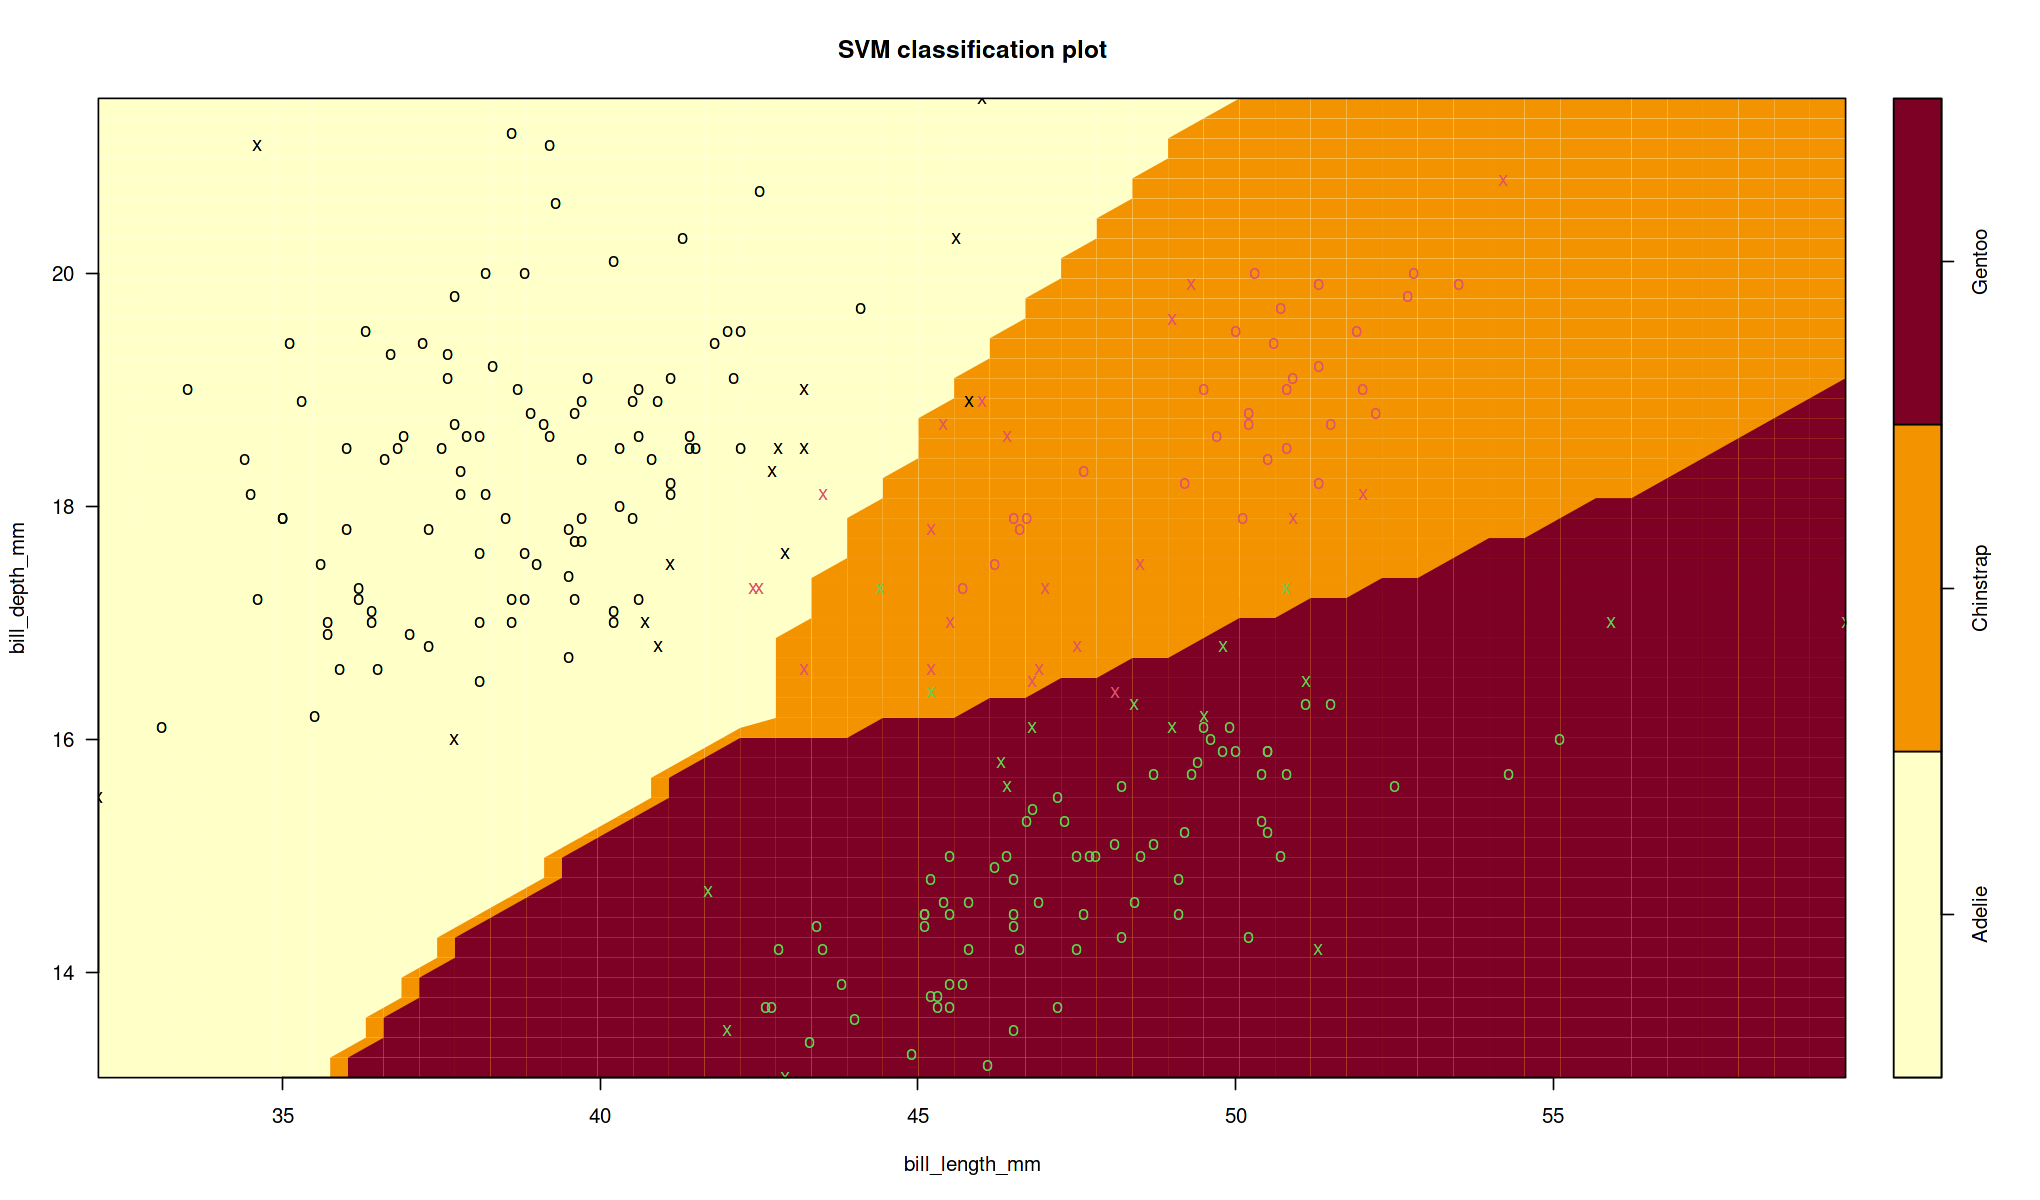

In [23]:
vars = c(1,3,4)
vars2 = c(3,4)

classifier <- randomForest(species ~., data = dataset[vars],importance = T,
                          maxnodes = 11, ntree = 500) 
predicted_table <- predict(classifier,
                           validation[,vars2])
table(observed = validation[,Y_loc], predicted = predicted_table)

svm_model <- svm(species ~ ., data=dataset[vars],
                 kernel="radial") 
plot(svm_model, data=dataset[vars],
     bill_depth_mm~bill_length_mm)